# Simulation of N-body system
By: Magnus Kvåle Helliesen

We (or at least I) want to simulate the dynamics of an $N$-body system of (celestial) bodies. In order to do this, we make two classes, a **Body** and a **System** of bodies, that contain the neccesary information and methods to carry out such a simulation.

In [1]:
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, IntSlider
from physics.physics import Body, System

## Body class
We start by making a class containing all relevant information for any given body. That is, initial position, velocity and mass. In addition, we allow for updating of position and velocity for any given time. The Body class is implemented in the file [`physics.py`](physics/physics.py).

## System class
We then make a class that holds instances of body classes. The system class has a method to simulate how the bodies move over time according to
$\vec{F}_i = m_i\vec{a}_i \iff \vec{a}_i = \vec{F}_i/m_i$ for each body $i$. The (net) force acting on body $i$ is
$$
    \vec{F}_i = \sum_{j\neq i}\vec{F}_{ij}=-\sum_{j\neq i}G\frac{m_im_j}{|\vec{r}_{ij}|^2}\hat{\vec{r}}_{ij},
$$
where
$$
    \vec{r}_{ij}\equiv \vec{r}_i-\vec{r}_j,
$$
and $\hat{\vec{r}}_{ij}$ is normalized to have length 1. (That is, the bodies move according to Newton's rule motion and of gravitation.)

Further, we use the following approximations given some chosen $\Delta t$:
$$
    \vec{v}'_i(t_n)=a_i(t_n) \rightarrow \vec{v}_i(t_{n+1})\approx \vec{v}_i(t_n)+\Delta t \vec{a}_i(t_n),
$$
$$
    \vec{r}'_i(t_n)=\vec{r}_i(t_n) \rightarrow \vec{r}_i(t_{n+1})\approx \vec{r}_i(t_n)+\Delta t \vec{v}_i(t_n).
$$

All this taken together lets us approximate all future positions from the initial conditions (position, velocity and acceleration assumed to be zero).

The System class is implemented in the file [`physics.py`](physics/physics.py).

## Setting up and simulating
We set up a few bodies and put them into a system. We then simulate the system and plot the trajectories.

In [2]:
# We set up how we want the System class to behave
System.dim = 3
System.G = 2
System.N = 15000
System.delta_t = 0.01

In [3]:
# Defining some bodies
body1 = Body((4, 4, 2), (-1, 1, 0), 5)
body2 = Body((-4, -4, -2), (1, -1, 0), 5)
body3 = Body((0, 0, 0), (0, 0, 0), 3)

# And puting them in a system
system1 = System(body1, body2, body3)
system1

System in 3 dimension with 3 bodies

In [4]:
print(*[body for _, body in system1.bodies.items()], sep='\n')

Body with mass 5 and initial position (4, 4, 2) and velocity (-1, 1, 0)
Body with mass 5 and initial position (-4, -4, -2) and velocity (1, -1, 0)
Body with mass 3 and initial position (0, 0, 0) and velocity (0, 0, 0)


In [5]:
# We can now simulate how they move about
system1.simulate()

In [6]:
# We make a function that plots the simulations of a general System object
def plot_simulation(system: System, xylim: tuple=None, N_range: tuple=None):
    if N_range is None:
        N_range = (0, System.N)

    plt.figure(figsize=(10, 10))
    plt.axes(projection='3d')
    for i, col in zip(range(len(system)), ['r', 'b', 'g', 'k', 'm', 'c', 'y']):
        r = system.r[i][N_range[0]:N_range[1], :]
        plt.plot(
            r[:, 0],
            r[:, 1],
            r[:, 2],
            f'{col}--')
        plt.plot(
            r[-1, 0],
            r[-1, 1],
            r[-1, 2],
            f'{col}o', ms=5*(system.bodies[i].mass)**(2/3))
    if xylim is None:
        plt.axis('equal')
    else:
        plt.xlim(xylim)
        plt.ylim(xylim)
    plt.grid()
    plt.title(f'Trajectories for $t \in [{N_range[0]*System.delta_t}, {N_range[1]*System.delta_t:.2f}]$')
    plt.show()

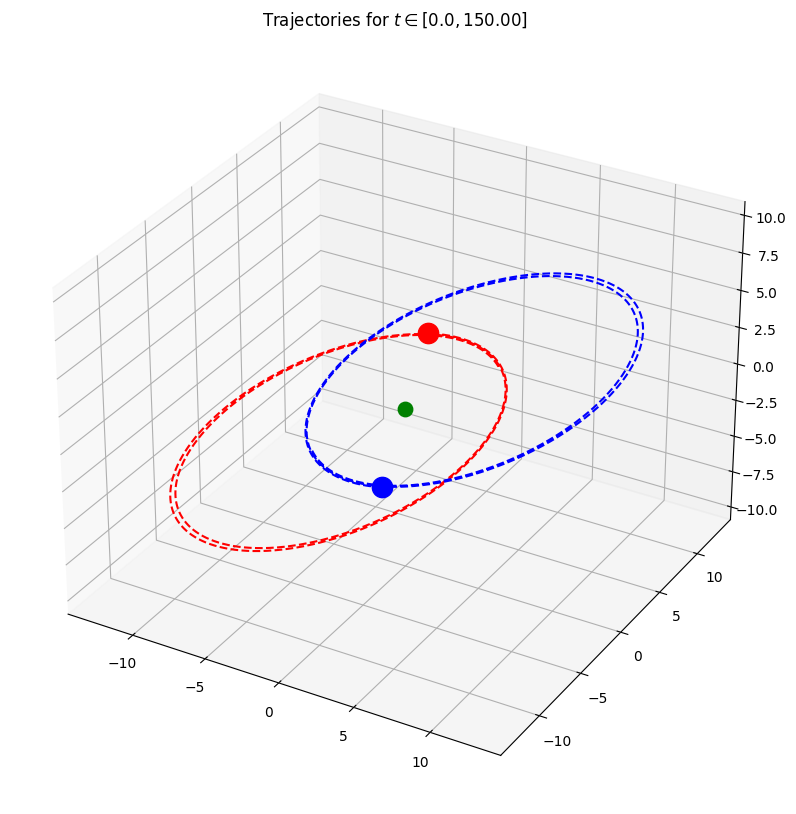

In [7]:
plot_simulation(system1)

## What happens if we introduce a tiny fourth body?

In [8]:
# We make a system like the one above, but where we introduce a TINY fourth body
body4 = Body((-8, 0, -8), (-1, -1, -1), 0.00001)
system2 = System(body1, body2, body3, body4)
system2

System in 3 dimension with 4 bodies

In [9]:
print(*[body for _, body in system2.bodies.items()], sep='\n')

Body with mass 5 and initial position (4, 4, 2) and velocity (-1, 1, 0)
Body with mass 5 and initial position (-4, -4, -2) and velocity (1, -1, 0)
Body with mass 3 and initial position (0, 0, 0) and velocity (0, 0, 0)
Body with mass 1e-05 and initial position (-8, 0, -8) and velocity (-1, -1, -1)


In [10]:
# We simulate again
system2.simulate()

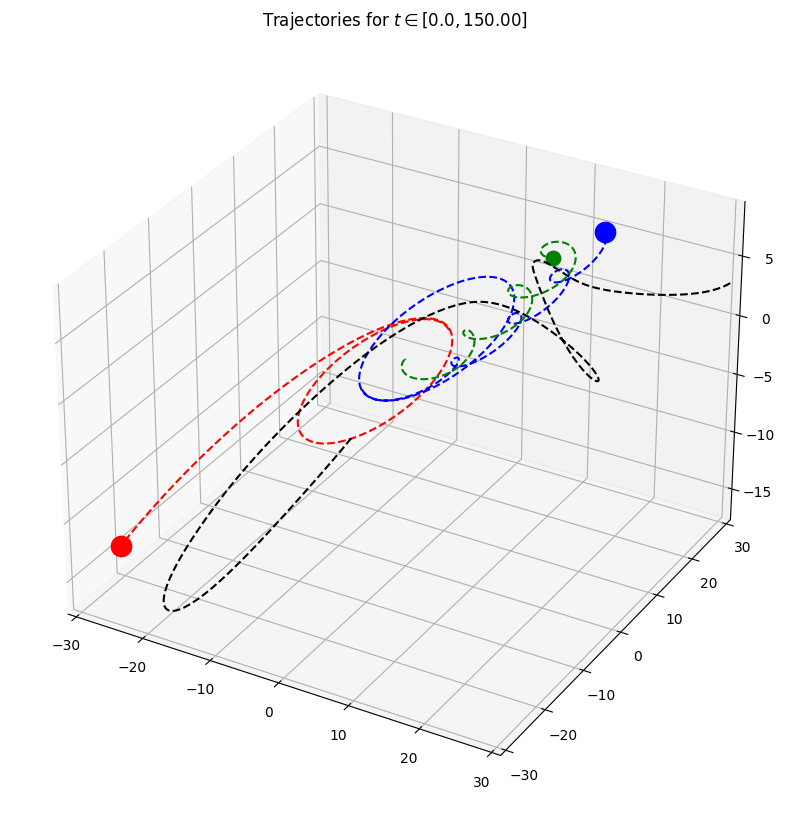

In [11]:
# And plot the curves that they trace out
plot_simulation(system2, (-30, 30))

The fourth body really messes up the trajectories. But it's difficult to see exactly what's going on. We can use an intslider to study subsets of the trajectories.

In [12]:
# Interacting plotting function with widget to allow for closer study of trajectories
@interact(to=IntSlider(value=1, min=0, max=System.N, step=50))
def plot_simulation_subset(to):
    plot_simulation(system2, (-30, 30), (max(to-2500, 0), to))

interactive(children=(IntSlider(value=1, description='to', max=15000, step=50), Output()), _dom_classes=('widg…

It appears as if the tiny body pushes the third on at (0, 0) out of it's position. Then it starts moving and interacting with the others, and the stability is ruined.